![Add a relevant banner image here](path_to_image)

# Project Title

## Overview

Short project description. Your bottom line up front (BLUF) insights.

## Business Understanding

Text here

## Data Understanding

Text here

In [1]:
# Load relevant imports here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, year, month, dayofmonth, hour, when
from pyspark.sql.types import TimestampType
import sqlite3
import seaborn as sns
import scipy.stats as stats

## Data Preparation
Text here

In [2]:
df = pd.read_csv('US_Accidents_March23.csv')

In [3]:
# Set option to display all columns
pd.set_option('display.max_columns', None)

# Now display the first few rows
df.head()

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,Source2,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,Right lane blocked due to accident on I-70 Eas...,I-70 E,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,Source2,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,Accident on Brice Rd at Tussing Rd. Expect del...,Brice Rd,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,Source2,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,Accident on OH-32 State Route 32 Westbound at ...,State Route 32,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,Source2,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,Accident on I-75 Southbound at Exits 52 52B US...,I-75 S,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,Source2,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,Accident on McEwen Rd at OH-725 Miamisburg Cen...,Miamisburg Centerville Rd,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day


## Analysis

Text here

In [41]:
print(df.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7541709 entries, 0 to 7541708
Data columns (total 52 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   Source                 object        
 2   Severity               int64         
 3   Start_Time             datetime64[ns]
 4   End_Time               datetime64[ns]
 5   Start_Lat              float64       
 6   Start_Lng              float64       
 7   End_Lat                float64       
 8   End_Lng                float64       
 9   Distance(mi)           float64       
 10  Description            object        
 11  Street                 object        
 12  City                   object        
 13  County                 object        
 14  State                  object        
 15  Zipcode                object        
 16  Country                object        
 17  Timezone               object        
 18  Airport_Code          

In [5]:
print(df.shape)

(7728394, 46)


In [6]:
df['Start_Time'] = pd.to_datetime(df['Start_Time'], format='mixed')
df['End_Time'] = pd.to_datetime(df['End_Time'], format='mixed')

In [7]:
df['Year'] = df['Start_Time'].dt.year
df['Month'] = df['Start_Time'].dt.month
df['Day'] = df['Start_Time'].dt.day
df['Hour'] = df['Start_Time'].dt.hour

In [40]:
# Get columns with missing values
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

# Get data types
dtypes = df.dtypes

# Combine missing values and data types into a DataFrame
missing_df = pd.DataFrame({
    'Missing_Values': missing,
    'Data_Type': dtypes[missing.index]
})

print(missing_df)

Empty DataFrame
Columns: [Missing_Values, Data_Type]
Index: []


In [9]:
# Fill missing End_Lat and End_Lng first
df['End_Lat'] = df['End_Lat'].fillna(df['Start_Lat'].round())
df['End_Lng'] = df['End_Lng'].fillna(df['Start_Lng'].round())

# Round to nearest whole number (0 decimal places)
df['Start_Lat'] = df['Start_Lat'].round()
df['Start_Lng'] = df['Start_Lng'].round()
df['End_Lat'] = df['End_Lat'].round()
df['End_Lng'] = df['End_Lng'].round()

In [10]:
# Drop rows where 'Weather_Condition' is missing
df = df[df['Weather_Condition'].notna()]
df = df[df['City'].notna()]

In [11]:
#Median Temperature by City + Month
city_month_temp = df.groupby(['City', 'Month'])['Temperature(F)'].median().reset_index()
city_month_temp.rename(columns={'Temperature(F)': 'CityMonth_Temp_Median'}, inplace=True)
df = df.merge(city_month_temp, on=['City', 'Month'], how='left')

#Fill using City + Month
df['Temperature(F)'] = df['Temperature(F)'].fillna(df['CityMonth_Temp_Median'])
df.drop(columns=['CityMonth_Temp_Median'], inplace=True)

#Median Temperature by State + Month (fallback)
state_month_temp = df.groupby(['State', 'Month'])['Temperature(F)'].median().reset_index()
state_month_temp.rename(columns={'Temperature(F)': 'StateMonth_Temp_Median'}, inplace=True)
df = df.merge(state_month_temp, on=['State', 'Month'], how='left')

#Fill using State + Month
df['Temperature(F)'] = df['Temperature(F)'].fillna(df['StateMonth_Temp_Median'])
df.drop(columns=['StateMonth_Temp_Median'], inplace=True)

# Filter to valid temperature range
df = df[(df['Temperature(F)'] >= -30) & (df['Temperature(F)'] <= 130)]


In [12]:
#Main Median — City + Weather_Condition + Month
city_group = df.groupby(['City', 'Weather_Condition', 'Month'])['Precipitation(in)'].median().reset_index()
city_group.rename(columns={'Precipitation(in)': 'Median_City'}, inplace=True)
df = df.merge(city_group, on=['City', 'Weather_Condition', 'Month'], how='left')
df['Precipitation(in)'] = df['Precipitation(in)'].fillna(df['Median_City'])
df.drop(columns=['Median_City'], inplace=True)

#Fallback — State + Weather_Condition + Month
state_group = df.groupby(['State', 'Weather_Condition', 'Month'])['Precipitation(in)'].median().reset_index()
state_group.rename(columns={'Precipitation(in)': 'Median_State'}, inplace=True)
df = df.merge(state_group, on=['State', 'Weather_Condition', 'Month'], how='left')
df['Precipitation(in)'] = df['Precipitation(in)'].fillna(df['Median_State'])
df.drop(columns=['Median_State'], inplace=True)

In [13]:
df = df[df['Precipitation(in)'].notna()]

In [14]:
# Select only object columns with missing values
object_cols_with_na = df.select_dtypes(include='object').columns
object_cols_with_na = [col for col in object_cols_with_na if df[col].isna().sum() > 0]

# Fill missing values with 'Unknown'
df[object_cols_with_na] = df[object_cols_with_na].fillna('Unknown')

In [15]:
# Main Median — City + Weather_Condition + Month
humidity_city = df.groupby(['City', 'Weather_Condition', 'Month'])['Humidity(%)'].median().reset_index()
humidity_city.rename(columns={'Humidity(%)': 'Median_City_Humidity'}, inplace=True)

df = df.merge(humidity_city, on=['City', 'Weather_Condition', 'Month'], how='left')
df['Humidity(%)'] = df['Humidity(%)'].fillna(df['Median_City_Humidity'])
df.drop(columns=['Median_City_Humidity'], inplace=True)

# Fallback Median — State + Weather_Condition + Month
humidity_state = df.groupby(['State', 'Weather_Condition', 'Month'])['Humidity(%)'].median().reset_index()
humidity_state.rename(columns={'Humidity(%)': 'Median_State_Humidity'}, inplace=True)

df = df.merge(humidity_state, on=['State', 'Weather_Condition', 'Month'], how='left')
df['Humidity(%)'] = df['Humidity(%)'].fillna(df['Median_State_Humidity'])
df.drop(columns=['Median_State_Humidity'], inplace=True)

In [16]:
df = df[df['Humidity(%)'].notna()]

In [17]:
# Drop Wind_Chill(F)
df.drop(columns=['Wind_Chill(F)'], inplace=True)

# List of columns to impute
cols_to_impute = ['Wind_Speed(mph)', 'Visibility(mi)', 'Pressure(in)']

for col in cols_to_impute:
    # 1. City + Weather + Month
    g1 = df.groupby(['City', 'Weather_Condition', 'Month'])[col].median().reset_index()
    g1.rename(columns={col: f'G1_{col}'}, inplace=True)
    df = df.merge(g1, on=['City', 'Weather_Condition', 'Month'], how='left')

    # 2. State + Weather + Month
    g2 = df.groupby(['State', 'Weather_Condition', 'Month'])[col].median().reset_index()
    g2.rename(columns={col: f'G2_{col}'}, inplace=True)
    df = df.merge(g2, on=['State', 'Weather_Condition', 'Month'], how='left')

    # Fill in order: G1 → G2 → global median
    global_med = df[col].median()
    df[col] = df[col].fillna(df[f'G1_{col}']) \
                     .fillna(df[f'G2_{col}']) \
                     .fillna(global_med)

    # Drop temp columns
    df.drop(columns=[f'G1_{col}', f'G2_{col}'], inplace=True)

In [18]:
df.dropna(subset=['Wind_Speed(mph)', 'Visibility(mi)', 'Pressure(in)'], inplace=True)

In [19]:
# Handle numeric columns with appropriate values
df['Wind_Speed(mph)'] = df['Wind_Speed(mph)'].fillna(df['Wind_Speed(mph)'].median())
df['Pressure(in)'] = df['Pressure(in)'].fillna(df['Pressure(in)'].median())
df['Weather_Timestamp'] = df['Weather_Timestamp'].fillna(df['Start_Time'])

# Handle categorical columns with string or mode
df['Wind_Direction'] = df['Wind_Direction'].fillna('Unknown')
df['Weather_Condition'] = df['Weather_Condition'].fillna('Unknown')
df['Airport_Code'] = df['Airport_Code'].fillna('Unknown')
df['Street'] = df['Street'].fillna('Unknown')
df['Zipcode'] = df['Zipcode'].fillna('Unknown')
df['City'] = df['City'].fillna('Unknown')
df['Description'] = df['Description'].fillna('Unknown')

# Fill twilight-related columns with mode
twilight_cols = ['Nautical_Twilight', 'Civil_Twilight', 'Sunrise_Sunset', 'Astronomical_Twilight']
for col in twilight_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


In [20]:
# Get min and max temps and floor/ceil to nearest 5
import numpy as np

min_temp = int(np.floor(df['Temperature(F)'].min() / 5) * 5)
max_temp = int(np.ceil(df['Temperature(F)'].max() / 5) * 5)

# Create even 5°F bins
bins = list(range(min_temp, max_temp + 5, 5))
labels = [f"{b}–{b+4}" for b in bins[:-1]]  # e.g., 35–39, 40–44

# Add bucket column
df['Temperature_Bucket'] = pd.cut(
    df['Temperature(F)'],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=False  # Make bins left-inclusive, right-exclusive
)


In [21]:
# Sort by temperature ascending and get the lowest 10
lowest_temps = df.sort_values(by='Temperature(F)').head(10)

# Display the result
lowest_temps

,ID,Source,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Street,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Year,Month,Day,Hour,Temperature_Bucket
4833628,A-4983136,Source1,2,2022-12-22 21:25:08,2022-12-22 22:44:47,46.0,-111.0,46.0,-111.0,0.136,Incident on THEISEN RANCH RD near THEISEN RD D...,Theisen Rd,Belgrade,Gallatin,MT,59714-8130,US,US/Mountain,KBZN,2022-12-22 21:16:00,-30.0,64.0,25.85,4.0,CALM,0.0,0.0,Haze,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,2022,12,22,21,-30–-26
4290083,A-4422192,Source1,2,2022-02-25 07:46:07,2022-02-25 09:04:06,47.0,-95.0,47.0,-95.0,0.016,Incident on US-71 near MM 314 Drive with caution.,Paul Bunyan Dr NW,Bemidji,Beltrami,MN,56601,US,US/Central,KBJI,2022-02-25 07:55:00,-30.0,73.0,28.94,7.0,CALM,0.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day,2022,2,25,7,-30–-26
5074243,A-5231330,Source1,2,2022-12-22 09:27:37,2022-12-22 10:45:37,47.0,-112.0,47.0,-112.0,0.086,Incident on US-12 near LANE AVE Drive with cau...,E US Highway 12,East Helena,Lewis and Clark,MT,59635,US,US/Mountain,KHLN,2022-12-22 09:05:00,-30.0,68.0,26.64,10.0,CALM,0.0,0.0,Fair,False,False,True,False,False,False,True,False,False,False,False,True,False,Day,Day,Day,Day,2022,12,22,9,-30–-26
5190228,A-5351063,Source1,2,2022-12-22 09:03:49,2022-12-22 10:24:37,47.0,-112.0,47.0,-112.0,0.102,Incident on MONTANA AVE near MILL RD Drive wit...,N Montana Ave,Helena,Lewis and Clark,MT,59602-7227,US,US/Mountain,KHLN,2022-12-22 09:05:00,-30.0,63.0,26.64,10.0,CALM,0.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Day,Day,Day,Day,2022,12,22,9,-30–-26
6166768,A-6356145,Source1,2,2021-02-14 01:57:57,2021-02-14 06:42:57,46.0,-106.0,46.0,-106.0,0.255,Incident on WELLS RD near COWCREEK RD Drive wi...,Rosebud Creek Rd,Forsyth,Rosebud,MT,59327-9522,US,US/Mountain,KM46,2021-02-14 01:53:00,-30.0,61.0,27.70,10.0,NW,5.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,2021,2,14,1,-30–-26
2403168,A-2457852,Source2,3,2018-11-14 20:13:21,2018-11-14 20:42:39,33.0,-118.0,33.0,-118.0,0.000,Two lanes blocked due to accident on I-5 South...,San Diego Fwy S,San Clemente,San Diego,CA,92672,US,US/Pacific,KNXF,2018-11-14 19:56:00,-29.9,63.0,30.44,10.0,Calm,6.9,0.0,Clear,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,2018,11,14,20,-30–-26
4626486,A-4769420,Source1,2,2022-02-25 02:45:14,2022-02-25 04:45:53,48.0,-93.0,48.0,-93.0,0.101,Accident on MN-73 (US-53) from MN-1/Ashawa Rd ...,Highway 53,Cook,St. Louis,MN,55723-8136,US,US/Central,KCQM,2022-02-25 02:37:00,-29.0,68.0,28.96,10.0,CALM,0.0,0.0,Fair,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,2022,2,25,2,-30–-26
4299173,A-4431593,Source1,2,2022-12-21 23:18:42,2022-12-22 00:36:36,46.0,-111.0,46.0,-111.0,0.086,Incident on GOOCH HILL RD near GANT RD Drive w...,Gooch Hill Rd,Bozeman,Gallatin,MT,59718-6920,US,US/Mountain,KBZN,2022-12-21 22:56:00,-29.0,77.0,25.89,4.0,SSE,7.0,0.0,Haze,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night,2022,12,21,23,-30–-26
2316872,A-2369469,Source2,2,2019-01-30 08:00:50,2019-01-30 08:30:35,45.0,-93.0,45.0,-93.0,0.000,Accident on US-169 at CR-81 Bottineau Blvd.,US-169 S,Minneapolis,Hennepin,MN,55445,US,US/Central,KMIC,2019-01-30 07:53:00,-29.0,69.0,30.37,6.0,WNW,10.4,0.0,Haze,False,False,False,False,False,False,False,False,False,False,False,F

In [22]:
# Save the cleaned DataFrame to a new CSV file
df.to_csv('US_Accidents_Cleaned.csv', index=False)

### Charts

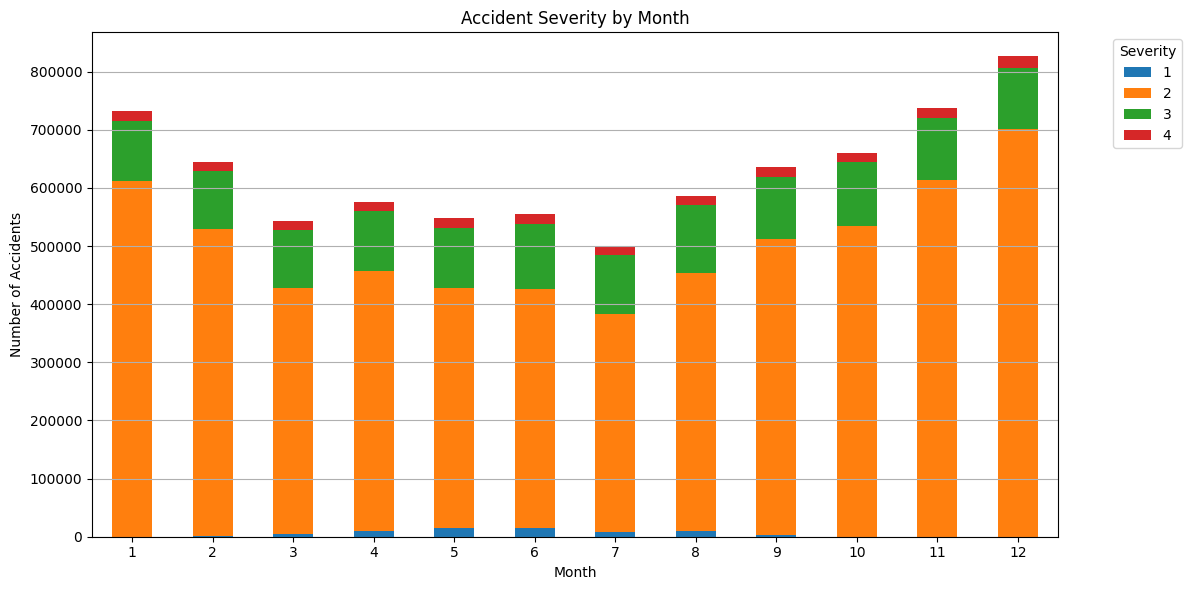

In [56]:
# Create crosstab of Month vs Severity
month_severity = pd.crosstab(df['Month'], df['Severity'])

# Sort by month number
month_severity = month_severity.sort_index()

# Plot stacked bar chart
month_severity.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Accident Severity by Month')
plt.xlabel('Month')
plt.ylabel('Number of Accidents')
plt.legend(title='Severity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

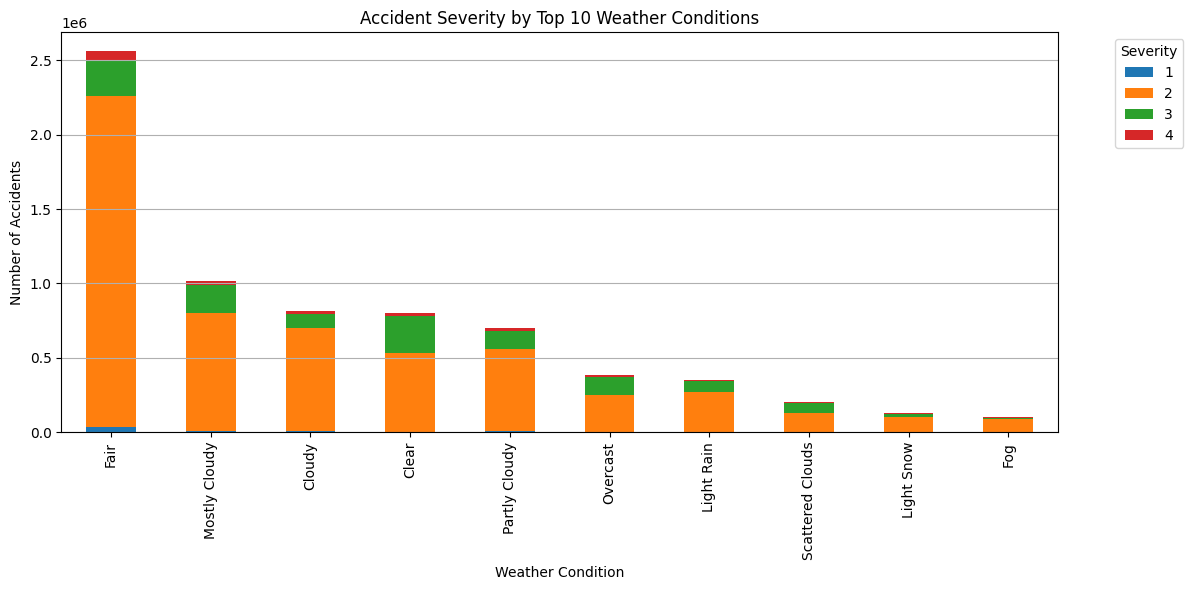

In [55]:
# Get the top 10 weather conditions by count
top_weather = df['Weather_Condition'].value_counts().head(10).index

# Filter the DataFrame
filtered_df = df[df['Weather_Condition'].isin(top_weather)]

# Create crosstab: Weather Condition vs Severity
weather_severity = pd.crosstab(filtered_df['Weather_Condition'], filtered_df['Severity'])

# Sort by total accidents (row sum) descending
weather_severity = weather_severity.loc[weather_severity.sum(axis=1).sort_values(ascending=False).index]

# Plot
weather_severity.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Accident Severity by Top 10 Weather Conditions')
plt.xlabel('Weather Condition')
plt.ylabel('Number of Accidents')
plt.legend(title='Severity', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(axis='y')
plt.show()

City
Miami            185323
Houston          167243
Los Angeles      155834
Charlotte        138375
Dallas           130455
Orlando          109304
Austin            95645
Raleigh           85955
Nashville         72726
Baton Rouge       71280
Atlanta           67864
Sacramento        66039
San Diego         55328
Phoenix           52542
Minneapolis       51385
Richmond          47156
Oklahoma City     45351
Jacksonville      42284
Tucson            38359
San Antonio       37821
Name: count, dtype: int64


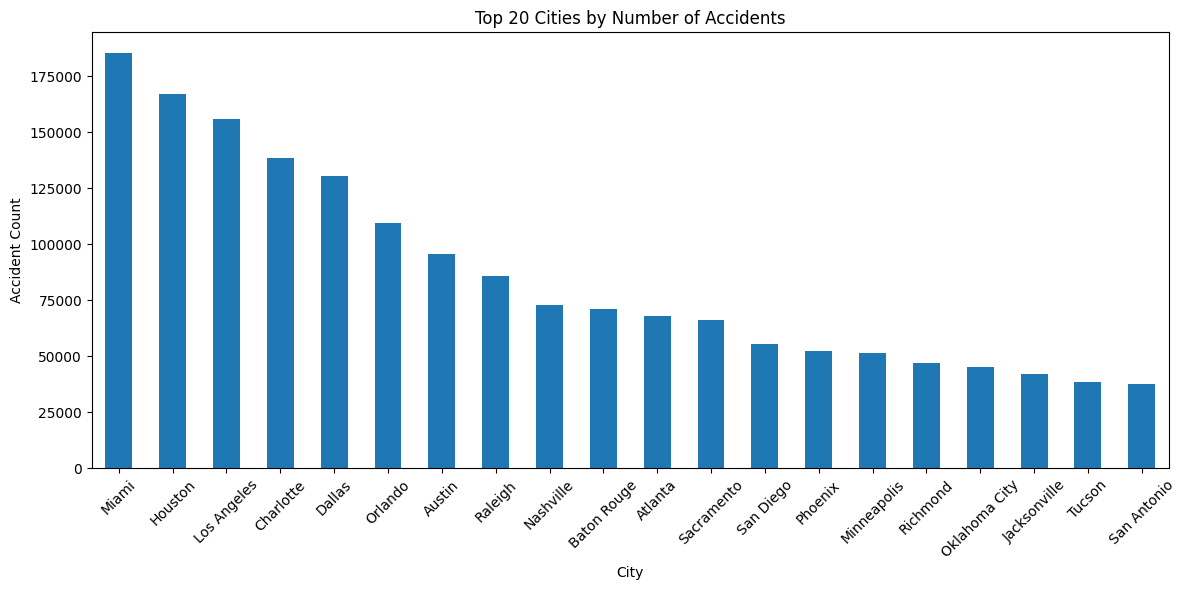

In [25]:
import matplotlib.pyplot as plt

top_cities = df['City'].value_counts().head(20)
print(top_cities)

plt.figure(figsize=(12, 6))
top_cities.plot(kind='bar')
plt.title('Top 20 Cities by Number of Accidents')
plt.ylabel('Accident Count')
plt.xlabel('City')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

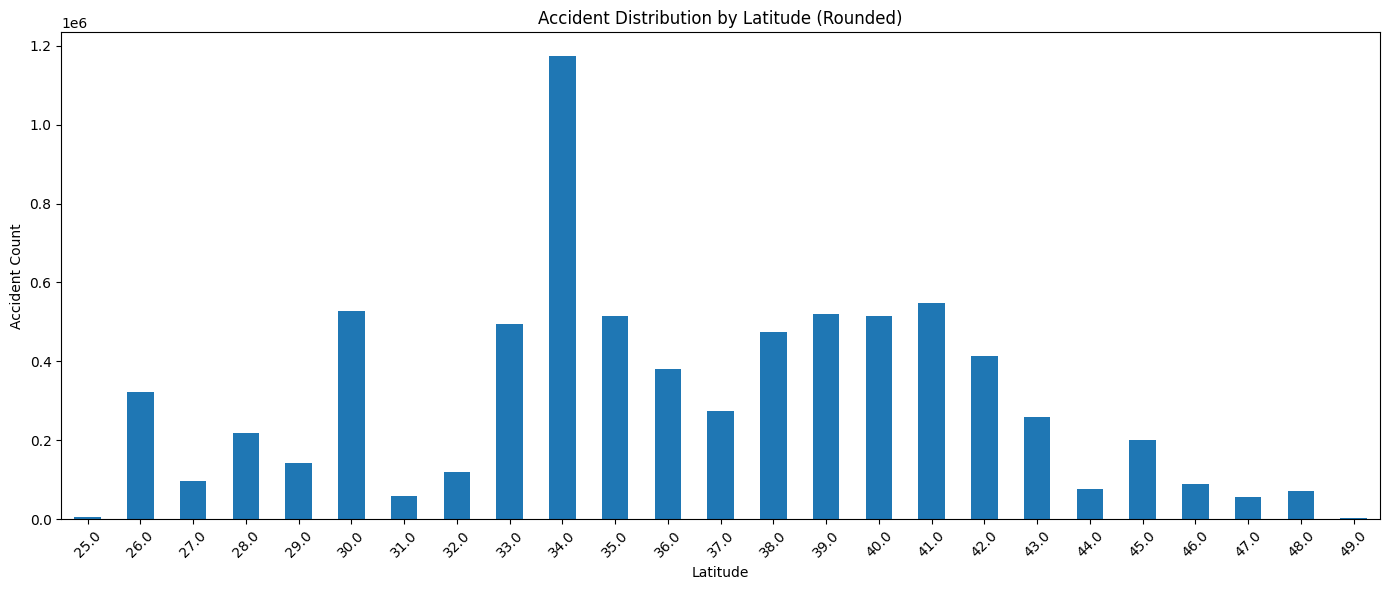

In [26]:
# Count of accidents per rounded latitude bucket
lat_counts = df['Start_Lat'].value_counts().sort_index()

# Plot
plt.figure(figsize=(14, 6))
lat_counts.plot(kind='bar')
plt.title('Accident Distribution by Latitude (Rounded)')
plt.xlabel('Latitude')
plt.ylabel('Accident Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [27]:
# Group by City to compute accident count and average latitude
top_cities_lat = df.groupby('City').agg({
    'ID': 'count',
    'Start_Lat': 'mean'
}).rename(columns={
    'ID': 'Accident_Count',
    'Start_Lat': 'Average_Latitude'
})

# Sort by accident count and get the top 20
top_20_cities_lat = top_cities_lat.sort_values(by='Accident_Count', ascending=False).head(50).reset_index()

# Display the result
print(top_20_cities_lat)

               City  Accident_Count  Average_Latitude
0             Miami          185323         26.004695
1           Houston          167243         30.014243
2       Los Angeles          155834         34.000000
3         Charlotte          138375         35.017012
4            Dallas          130455         33.041110
5           Orlando          109304         28.493257
6            Austin           95645         30.085859
7           Raleigh           85955         35.999395
8         Nashville           72726         35.999972
9       Baton Rouge           71280         30.090600
10          Atlanta           67864         34.002623
11       Sacramento           66039         38.831191
12        San Diego           55328         33.000000
13          Phoenix           52542         33.429809
14      Minneapolis           51385         45.000000
15         Richmond           47156         37.896577
16    Oklahoma City           45351         35.365306
17     Jacksonville         

C:\Users\steve\AppData\Local\Temp\ipykernel_26228\525110624.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data_1 = df.groupby(['Temperature_Bucket', 'Month']).size().unstack(fill_value=0)


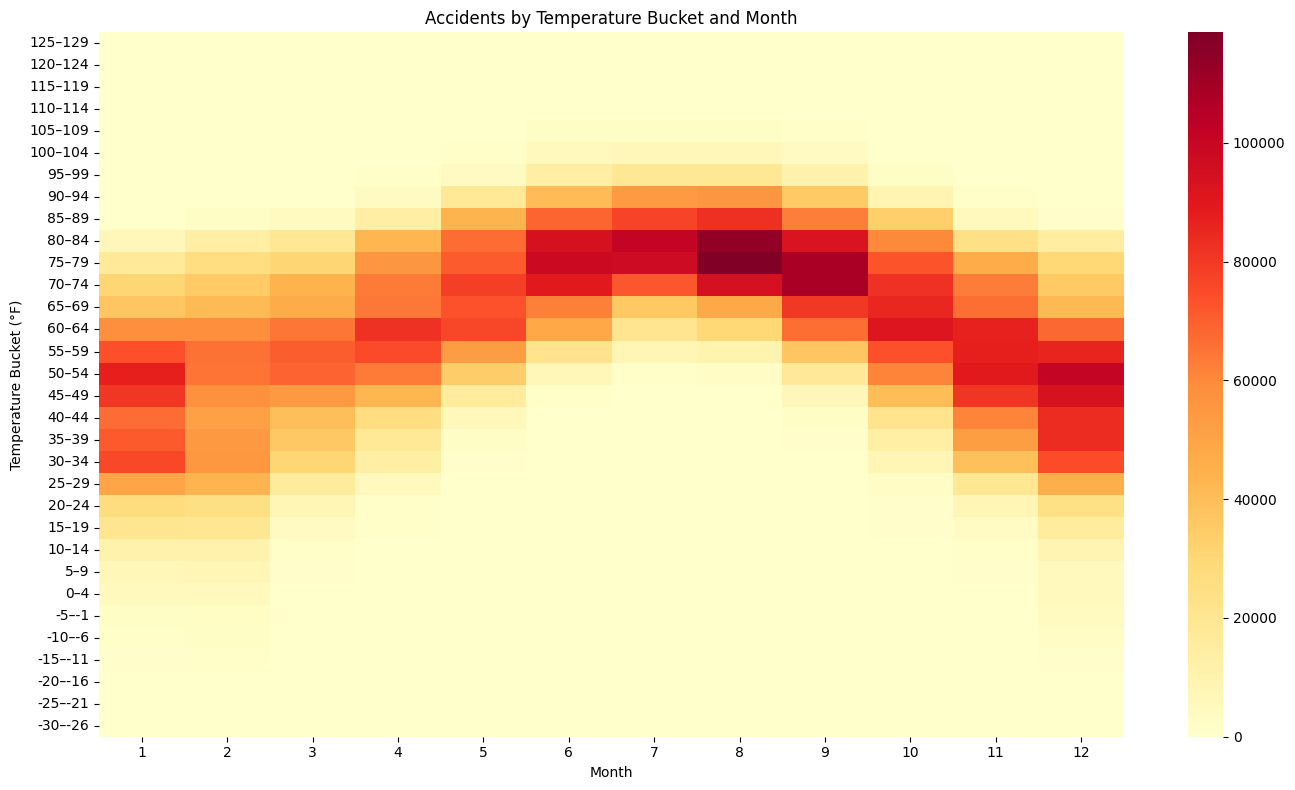

C:\Users\steve\AppData\Local\Temp\ipykernel_26228\525110624.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data_2 = df.groupby(['Region', 'Temperature_Bucket']).size().unstack(fill_value=0)


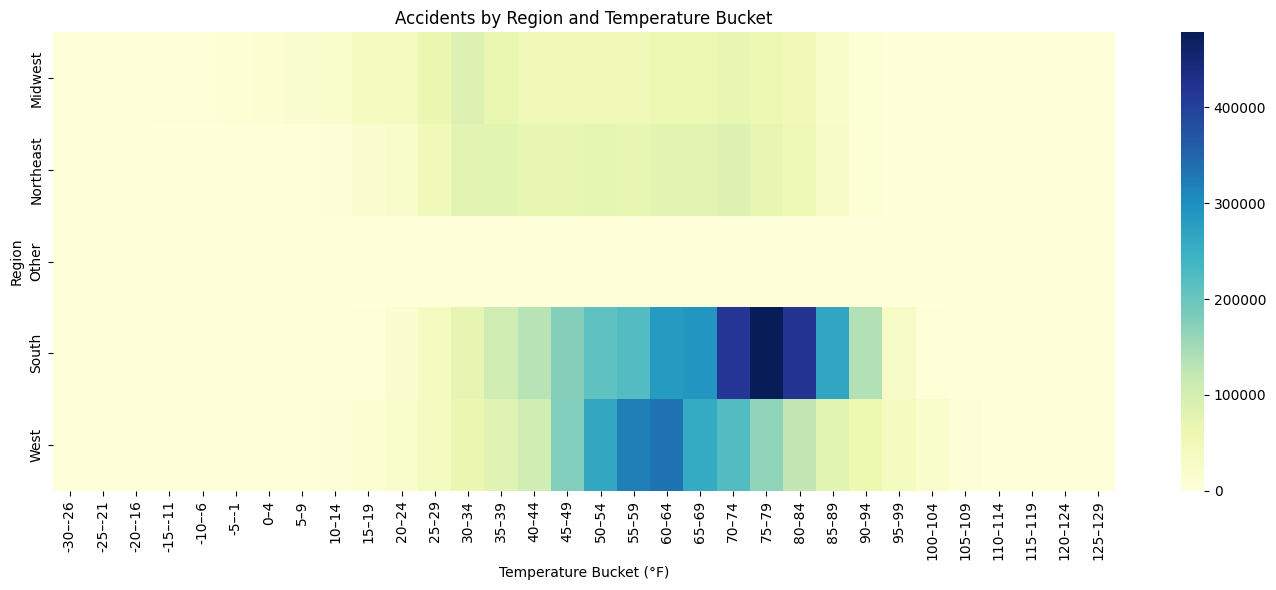

In [28]:
# Region map
region_map = {
    'South': ['TX', 'FL', 'GA', 'NC', 'SC', 'AL', 'MS', 'TN', 'KY', 'LA', 'AR', 'OK', 'VA', 'WV', 'MD', 'DE'],
    'Midwest': ['IL', 'IN', 'IA', 'KS', 'MI', 'MN', 'MO', 'ND', 'NE', 'OH', 'SD', 'WI'],
    'West': ['CA', 'WA', 'OR', 'NV', 'AZ', 'UT', 'CO', 'ID', 'MT', 'WY', 'NM'],
    'Northeast': ['NY', 'NJ', 'PA', 'CT', 'MA', 'ME', 'NH', 'RI', 'VT']
}
df['Region'] = df['State'].map(lambda x: next((region for region, states in region_map.items() if x in states), 'Other'))

# Heatmap: Accidents by Temperature Bucket and Month
heatmap_data_1 = df.groupby(['Temperature_Bucket', 'Month']).size().unstack(fill_value=0)
plt.figure(figsize=(14, 8))
ax = sns.heatmap(heatmap_data_1, cmap="YlOrRd")
ax.invert_yaxis()
plt.title('Accidents by Temperature Bucket and Month')
plt.xlabel('Month')
plt.ylabel('Temperature Bucket (°F)')
plt.tight_layout()
plt.show()

# Heatmap: Accidents by Region and Temperature Bucket
heatmap_data_2 = df.groupby(['Region', 'Temperature_Bucket']).size().unstack(fill_value=0)
plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data_2, cmap="YlGnBu")
plt.title('Accidents by Region and Temperature Bucket')
plt.xlabel('Temperature Bucket (°F)')
plt.ylabel('Region')
plt.tight_layout()
plt.show()


C:\Users\steve\AppData\Local\Temp\ipykernel_26228\1738540135.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  severity_temp = df.groupby(['Temperature_Bucket', 'Severity']).size().unstack(fill_value=0)


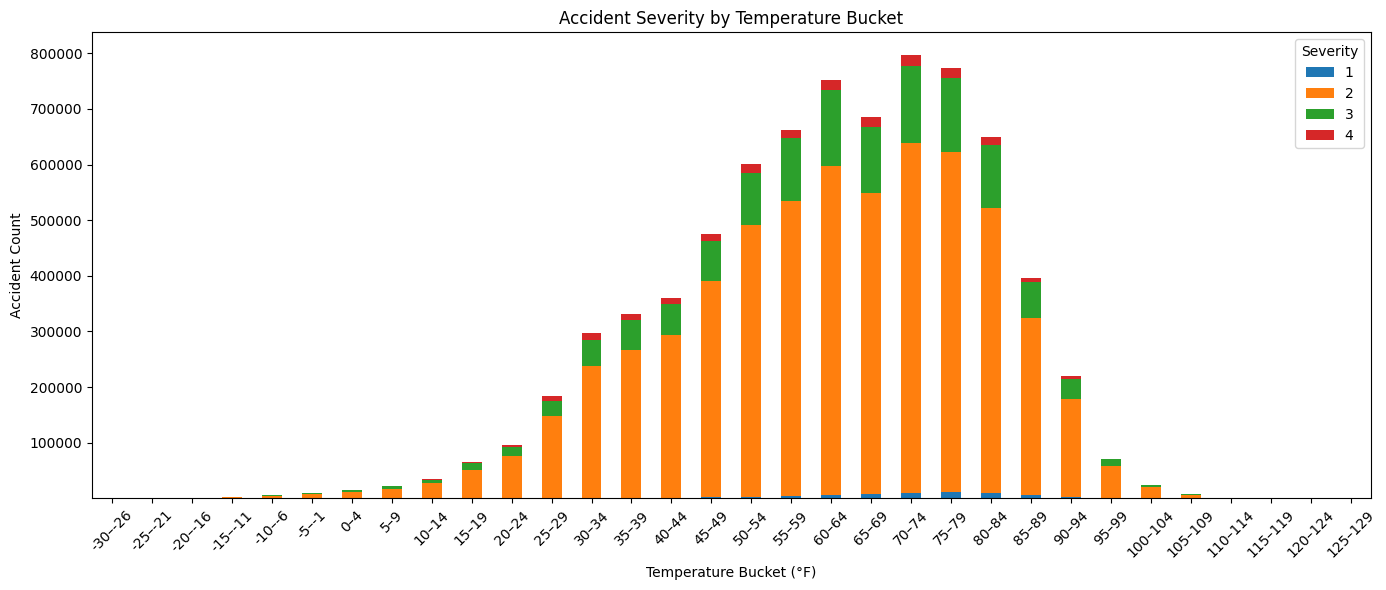

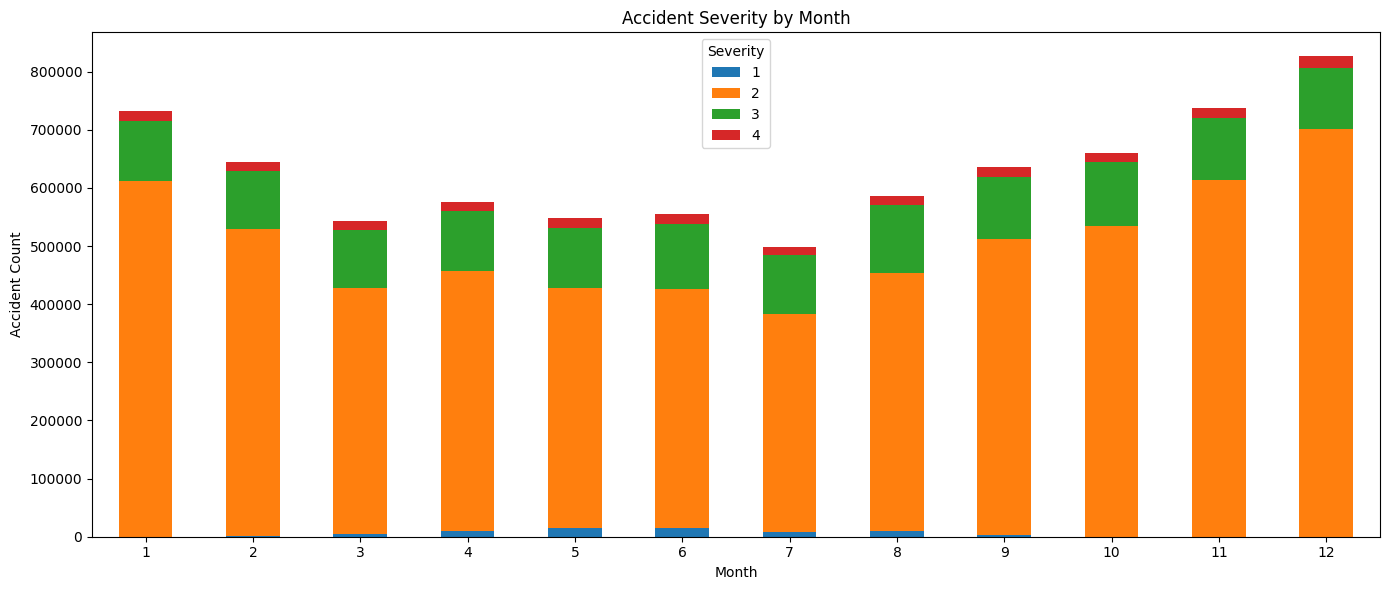

In [29]:
# Accident Severity by Temperature Bucket
severity_temp = df.groupby(['Temperature_Bucket', 'Severity']).size().unstack(fill_value=0)
severity_temp.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title('Accident Severity by Temperature Bucket')
plt.xlabel('Temperature Bucket (°F)')
plt.ylabel('Accident Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Accident Severity by Month
severity_month = df.groupby(['Month', 'Severity']).size().unstack(fill_value=0)
severity_month.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title('Accident Severity by Month')
plt.xlabel('Month')
plt.ylabel('Accident Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

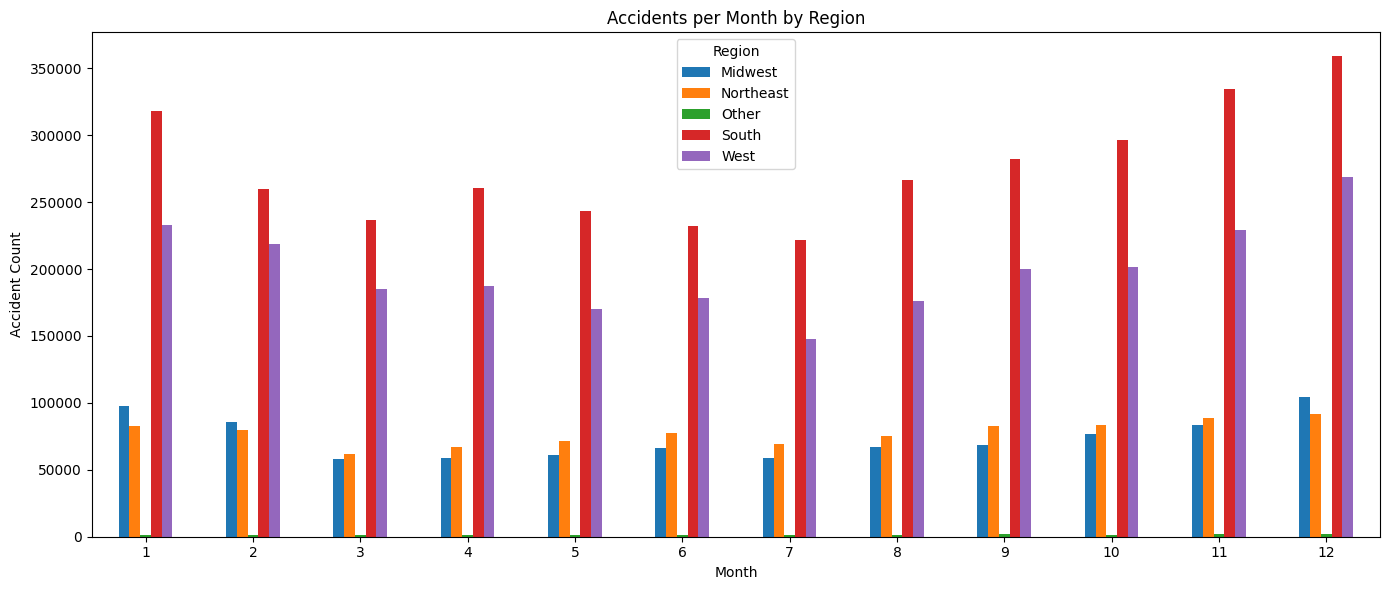

In [30]:
# Now group and plot
region_month_counts = df.groupby(['Region', 'Month']).size().unstack(fill_value=0)

region_month_counts.T.plot(kind='bar', figsize=(14, 6))
plt.title('Accidents per Month by Region')
plt.xlabel('Month')
plt.ylabel('Accident Count')
plt.legend(title='Region')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

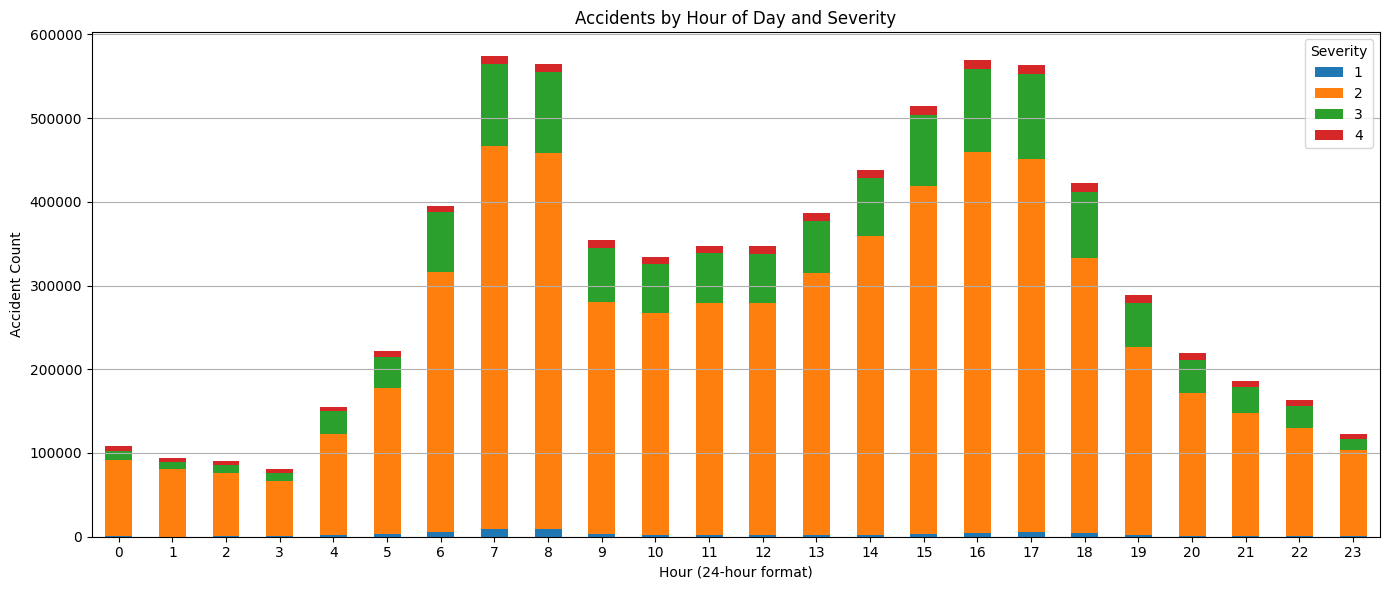

In [32]:
# Group by Hour and Severity
severity_hour = df.groupby(['Hour', 'Severity']).size().unstack(fill_value=0)

# Plot
severity_hour.plot(kind='bar', stacked=True, figsize=(14, 6))
plt.title('Accidents by Hour of Day and Severity')
plt.xlabel('Hour (24-hour format)')
plt.ylabel('Accident Count')
plt.xticks(rotation=0)
plt.legend(title='Severity')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

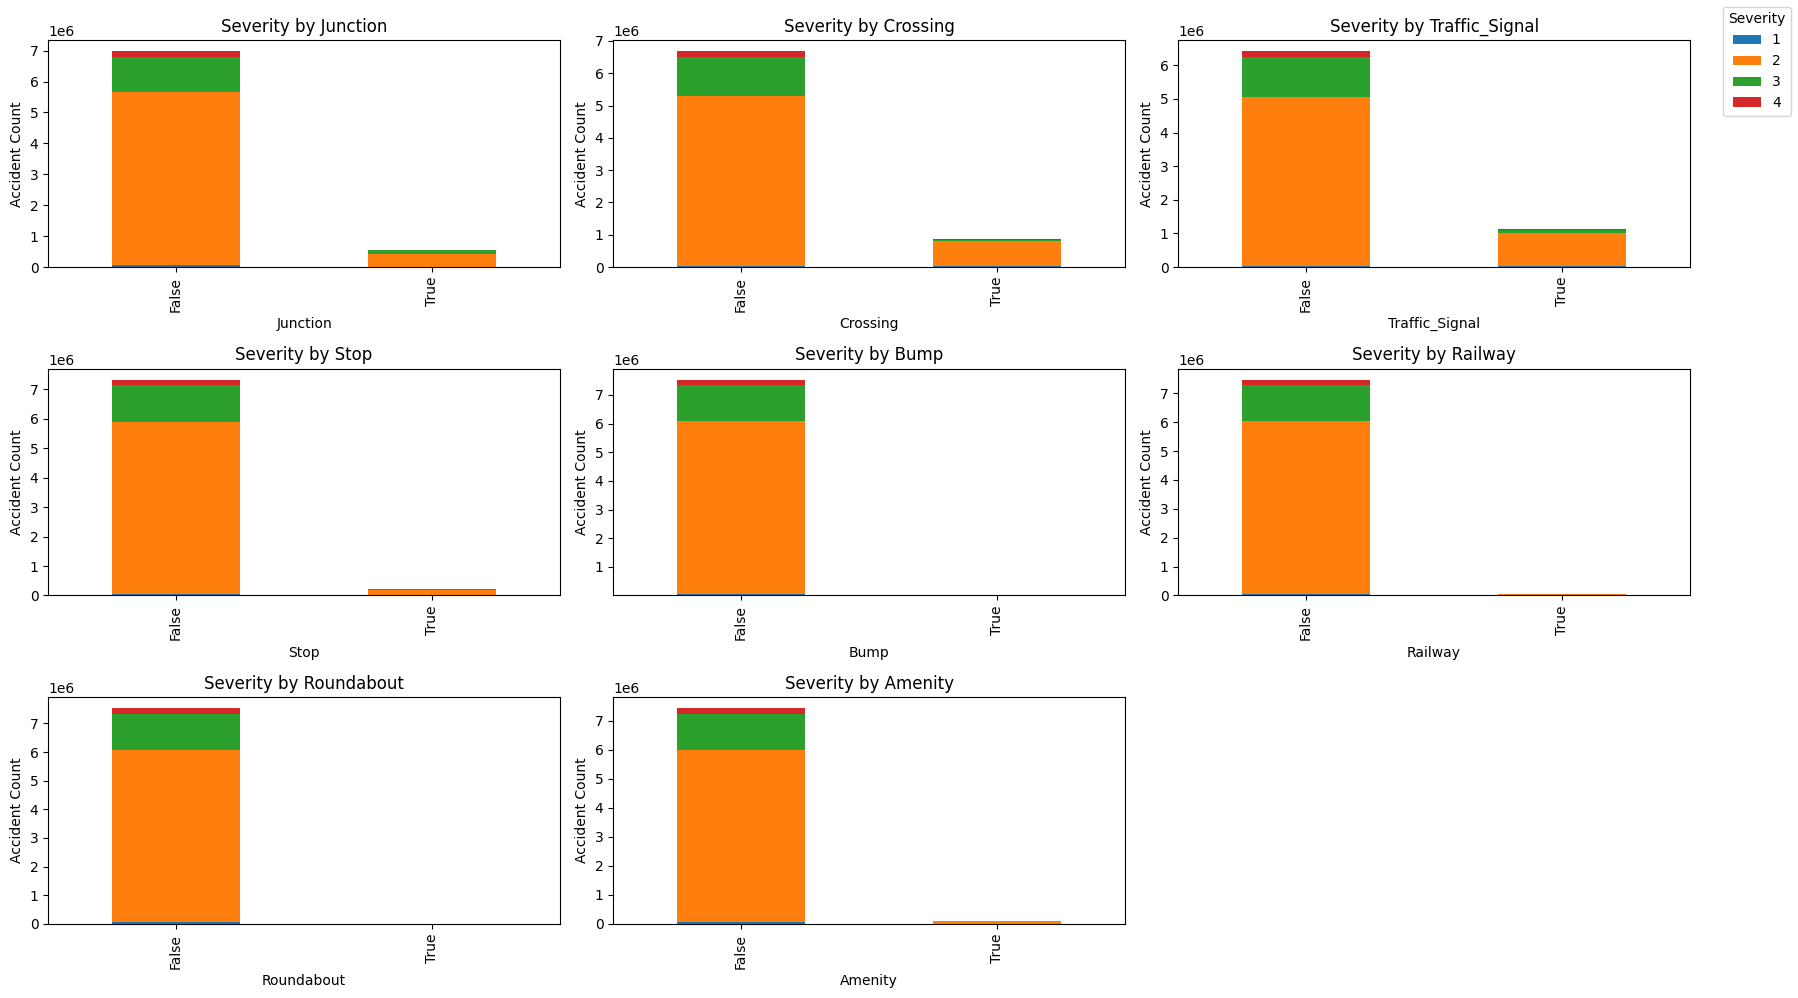

In [50]:
# List of road feature columns to analyze
road_features = [
    'Junction', 'Crossing', 'Traffic_Signal', 'Stop', 
    'Bump', 'Railway', 'Roundabout', 'Amenity'
]

n_cols = 3
n_rows = (len(road_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(18, 10))
axes = axes.flatten()

for i, feature in enumerate(road_features):
    crosstab = pd.crosstab(df[feature], df['Severity'])
    crosstab.plot(kind='bar', stacked=True, ax=axes[i], legend=False)
    axes[i].set_title(f'Severity by {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Accident Count')

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Severity', loc='upper right')

plt.tight_layout(rect=[0, 0, 0.95, 1])
plt.show()

### Analysis

In [59]:
def chi_square_test(df, feature, target='Severity', bins=None):
    if bins:
        binned_col = feature + '_binned'
        df[binned_col] = pd.cut(df[feature], bins=bins)
        feature_to_use = binned_col
    else:
        feature_to_use = feature

    contingency = pd.crosstab(df[feature_to_use], df[target])
    chi2, p, dof, _ = chi2_contingency(contingency)

    print(f"Feature: {feature}")
    print(f"Chi² Statistic: {chi2:.2f}")
    print(f"p-value: {p:.4e}")
    print(f"Degrees of Freedom: {dof}")
    print("Conclusion:", "Significant" if p < 0.05 else "Not significant")
    print("-" * 50)

# Binning strategies
temp_bins = list(range(-40, 140, 10))
humidity_bins = list(range(0, 110, 10))
visibility_bins = [0, 1, 3, 5, 10, 20, 100]
wind_speed_bins = [0, 5, 10, 15, 20, 30, 50, 100]
precip_bins = [0, 0.01, 0.1, 0.5, 1, 2, 5]
pressure_bins = [25, 27, 29, 30, 31, 32, 33]

# Replace with the correct column names if needed
features_to_test = [
    ('Temperature(F)', temp_bins),
    ('Humidity(%)', humidity_bins),
    ('Visibility(mi)', visibility_bins),
    ('Wind_Speed(mph)', wind_speed_bins),
    ('Precipitation(in)', precip_bins),
    ('Pressure(in)', pressure_bins)
    # ('Weather_Condition', None)  # Uncomment if correct name confirmed
]

for feature, bins in features_to_test:
    chi_square_test(df, feature, bins=bins)

Feature: Temperature(F)
Chi² Statistic: 38194.09
p-value: 0.0000e+00
Degrees of Freedom: 48
Conclusion: Significant
--------------------------------------------------
Feature: Humidity(%)
Chi² Statistic: 18025.44
p-value: 0.0000e+00
Degrees of Freedom: 27
Conclusion: Significant
--------------------------------------------------
Feature: Visibility(mi)
Chi² Statistic: 9372.81
p-value: 0.0000e+00
Degrees of Freedom: 15
Conclusion: Significant
--------------------------------------------------
Feature: Wind_Speed(mph)
Chi² Statistic: 4530.49
p-value: 0.0000e+00
Degrees of Freedom: 18
Conclusion: Significant
--------------------------------------------------
Feature: Precipitation(in)
Chi² Statistic: 1607.26
p-value: 0.0000e+00
Degrees of Freedom: 15
Conclusion: Significant
--------------------------------------------------
Feature: Pressure(in)
Chi² Statistic: 74222.86
p-value: 0.0000e+00
Degrees of Freedom: 15
Conclusion: Significant
--------------------------------------------------


In [60]:
# Function to run ANOVA tests
def run_anova_tests(df, numerical_features, target='Severity'):
    results = []

    for feature in numerical_features:
        df_clean = df[[feature, target]].dropna()
        groups = [group[feature].values for name, group in df_clean.groupby(target)]

        stat, p = f_oneway(*groups)

        results.append({
            'Feature': feature,
            'F-Statistic': stat,
            'p-value': p,
            'Conclusion': 'Significant' if p < 0.05 else 'Not significant'
        })

    return pd.DataFrame(results)

# Features to test
numerical_features = [
    'Temperature(F)', 'Humidity(%)', 'Visibility(mi)',
    'Wind_Speed(mph)', 'Precipitation(in)', 'Pressure(in)'
]

# Run the tests in your local environment
anova_results = run_anova_tests(df, numerical_features)
print(anova_results)

             Feature   F-Statistic        p-value   Conclusion
0     Temperature(F)   9870.222260   0.000000e+00  Significant
1        Humidity(%)   1502.029513   0.000000e+00  Significant
2     Visibility(mi)    472.015536  1.037514e-306  Significant
3    Wind_Speed(mph)   5327.162386   0.000000e+00  Significant
4  Precipitation(in)   1807.557261   0.000000e+00  Significant
5       Pressure(in)  13591.968053   0.000000e+00  Significant


In [65]:
# Define binning rules
df['Temperature(F)_binned'] = pd.cut(df['Temperature(F)'], bins=np.arange(-40, 140 + 10, 10))
df['Humidity(%)_binned'] = pd.cut(df['Humidity(%)'], bins=np.arange(0, 110 + 10, 10))
df['Visibility(mi)_binned'] = pd.cut(df['Visibility(mi)'], bins=[0, 1, 3, 5, 10, 20, 100])
df['Wind_Speed(mph)_binned'] = pd.cut(df['Wind_Speed(mph)'], bins=[0, 5, 10, 15, 20, 30, 50, 100])
df['Precipitation(in)_binned'] = pd.cut(df['Precipitation(in)'], bins=[0, 0.01, 0.1, 0.5, 1, 2, 5])
df['Pressure(in)_binned'] = pd.cut(df['Pressure(in)'], bins=[25, 27, 29, 30, 31, 32, 33])

# Cramér's V calculation function
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# Evaluate each feature
features_binned = [
    'Temperature(F)_binned',
    'Humidity(%)_binned',
    'Visibility(mi)_binned',
    'Wind_Speed(mph)_binned',
    'Precipitation(in)_binned',
    'Pressure(in)_binned'
]

def interpret_cramers_v(v):
    if v < 0.05:
        return 'Negligible'
    elif v < 0.10:
        return 'Weak'
    elif v < 0.15:
        return 'Moderate'
    elif v < 0.25:
        return 'Relatively Strong'
    else:
        return 'Strong'

# Evaluate each feature
results = []
for feature in features_binned:
    contingency = pd.crosstab(df[feature], df['Severity'])
    v = cramers_v(contingency)
    interpretation = interpret_cramers_v(v)
    results.append((feature, v, interpretation))

# Create and display the DataFrame
cramers_df = pd.DataFrame(results, columns=['Feature', "Cramér's V", 'Association Strength'])
cramers_df = cramers_df.sort_values(by="Cramér's V", ascending=False)
print(cramers_df)


                    Feature  Cramér's V Association Strength
5       Pressure(in)_binned    0.057646                 Weak
0     Temperature(F)_binned    0.041087           Negligible
1        Humidity(%)_binned    0.028226           Negligible
4  Precipitation(in)_binned    0.025287           Negligible
2     Visibility(mi)_binned    0.020364           Negligible
3    Wind_Speed(mph)_binned    0.015155           Negligible


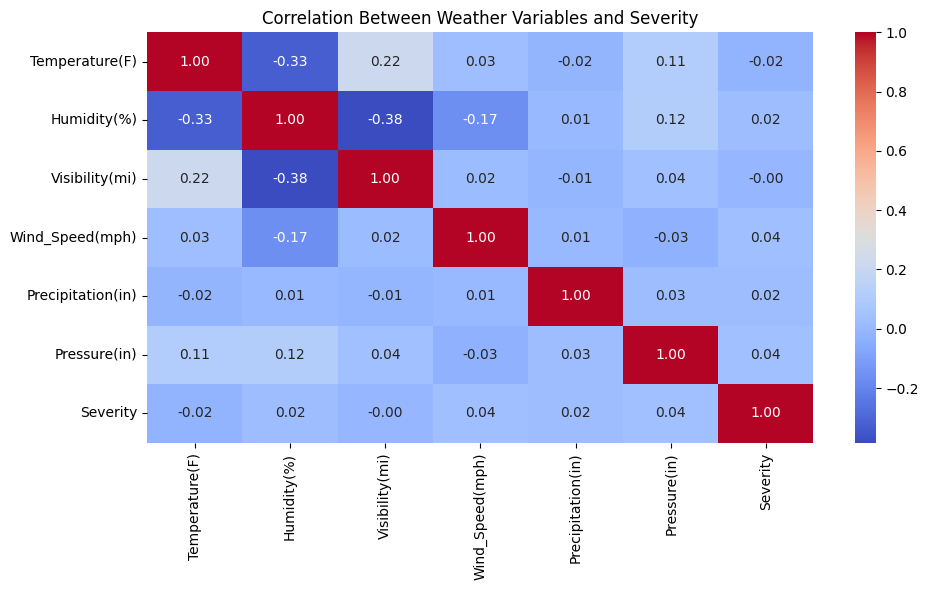

In [36]:
# 3. Correlation Matrix for Numerical Variables
num_cols = ['Temperature(F)', 'Humidity(%)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Pressure(in)', 'Severity']
corr_matrix = df[num_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Weather Variables and Severity")
plt.tight_layout()
plt.show()

In [61]:
print(df.columns.tolist())

['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Year', 'Month', 'Day', 'Hour', 'Temperature_Bucket', 'Region', 'Wind_Speed_Rounded', 'Visibility(mi)_binned', 'Wind_Speed_Rounded_binned', 'Temperature(F)_binned', 'Humidity(%)_binned', 'Wind_Speed(mph)_binned', 'Precipitation(in)_binned', 'Pressure(in)_binned']


In [45]:
from scipy.stats import chi2_contingency
import pandas as pd

# Features to test
features = ['Junction', 'Crossing', 'Traffic_Signal', 'Stop', 'Bump', 'Railway', 'Roundabout','Amenity']

# Store results
chi_square_results = {}

for feature in features:
    # Create contingency table
    contingency_table = pd.crosstab(df[feature], df['Severity'])

    # Perform chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Store results
    chi_square_results[feature] = {
        'Chi2 Statistic': chi2,
        'p-value': p,
        'Degrees of Freedom': dof
    }

# Display results with interpretation
for feature, result in chi_square_results.items():
    print(f"\nFeature: {feature}")
    print(f"Chi² Statistic: {result['Chi2 Statistic']:.2f}")
    print(f"p-value: {result['p-value']:.4e}")
    print(f"Degrees of Freedom: {result['Degrees of Freedom']}")

    if result['p-value'] < 0.05:
        print("Conclusion: There is a statistically significant association between this feature and accident severity.")
        print("This suggests that the presence or absence of", feature, "may influence the severity of accidents.")
    else:
        print("ℹConclusion: No statistically significant association was found.")
        print("The presence or absence of", feature, "does not appear to affect accident severity significantly.")



Feature: Junction
Chi² Statistic: 21210.41
p-value: 0.0000e+00
Degrees of Freedom: 3
Conclusion: There is a statistically significant association between this feature and accident severity.
This suggests that the presence or absence of Junction may influence the severity of accidents.

Feature: Crossing
Chi² Statistic: 111017.88
p-value: 0.0000e+00
Degrees of Freedom: 3
Conclusion: There is a statistically significant association between this feature and accident severity.
This suggests that the presence or absence of Crossing may influence the severity of accidents.

Feature: Traffic_Signal
Chi² Statistic: 111227.13
p-value: 0.0000e+00
Degrees of Freedom: 3
Conclusion: There is a statistically significant association between this feature and accident severity.
This suggests that the presence or absence of Traffic_Signal may influence the severity of accidents.

Feature: Stop
Chi² Statistic: 27075.49
p-value: 0.0000e+00
Degrees of Freedom: 3
Conclusion: There is a statistically signif

In [46]:
def cramers_v(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))

# Define interpretation of strength
def interpret_strength(v):
    if v < 0.05:
        return 'Negligible'
    elif v < 0.10:
        return 'Weak'
    elif v < 0.15:
        return 'Moderate'
    elif v < 0.25:
        return 'Relatively Strong'
    else:
        return 'Strong'

cramers_results = {}

for feature in features:
    contingency = pd.crosstab(df[feature], df['Severity'])
    cramer_v = cramers_v(contingency)
    cramers_results[feature] = cramer_v

# Create DataFrame
cramers_results_df = pd.DataFrame(
    list(cramers_results.items()),
    columns=['Feature', "Cramér's V"]
)

# Add interpretation column
cramers_results_df['Association Strength'] = cramers_results_df["Cramér's V"].apply(interpret_strength)

# Sort and display
cramers_results_df = cramers_results_df.sort_values(by="Cramér's V", ascending=False)

print(cramers_results_df)

          Feature  Cramér's V Association Strength
2  Traffic_Signal    0.121442             Moderate
1        Crossing    0.121328             Moderate
3            Stop    0.059917                 Weak
0        Junction    0.053032                 Weak
7         Amenity    0.038700           Negligible
5         Railway    0.013547           Negligible
4            Bump    0.005323           Negligible
6      Roundabout    0.002334           Negligible


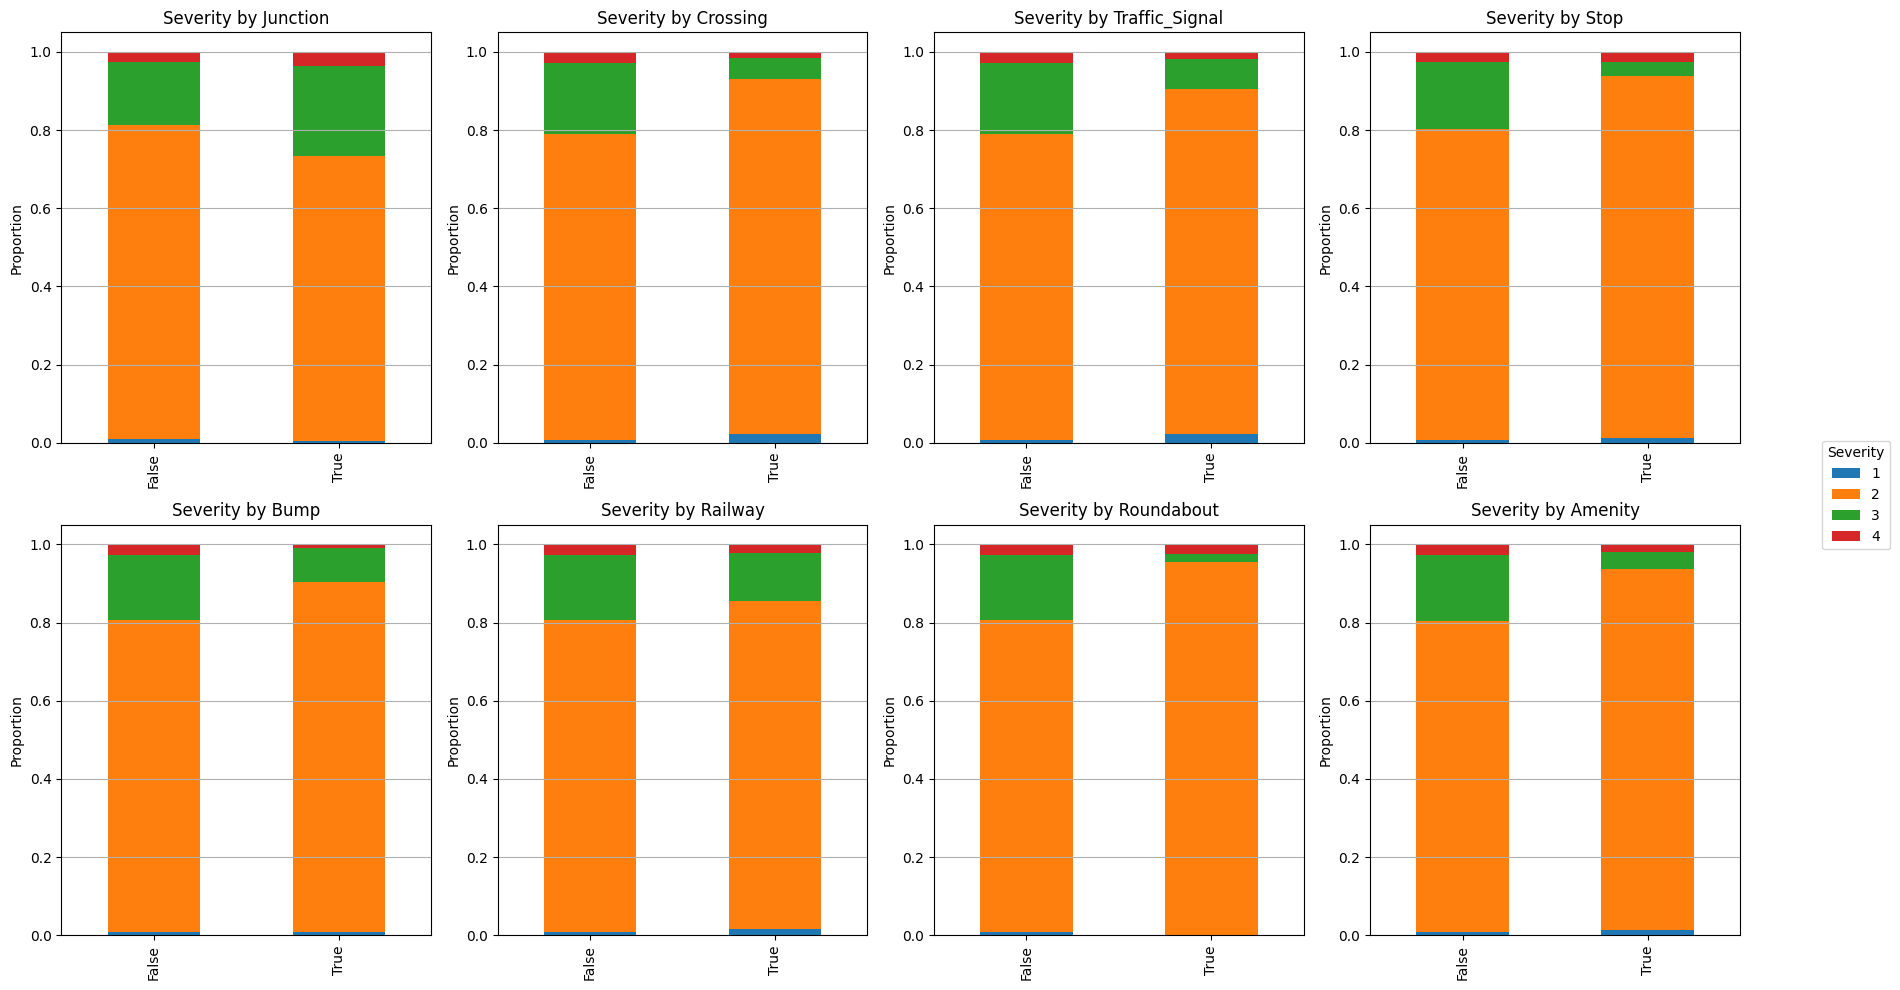

In [ ]:
# List of features to plot
features = [
    'Junction', 'Crossing', 'Traffic_Signal', 'Stop', 
    'Bump', 'Railway', 'Roundabout', 'Amenity'
]

# Setup the grid layout
n_cols = 4
n_rows = (len(features) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10))
axes = axes.flatten()

# Generate the plots
for i, feature in enumerate(features):
    ax = axes[i]
    severity_dist = (
        df.groupby([feature, 'Severity'])
        .size()
        .unstack()
        .div(df.groupby(feature).size(), axis=0)
    )
    severity_dist.plot(kind='bar', stacked=True, ax=ax, legend=False)
    ax.set_title(f'Severity by {feature}')
    ax.set_xlabel('')
    ax.set_ylabel('Proportion')
    ax.grid(axis='y')

# Remove unused axes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Place one legend outside the grid
fig.tight_layout(rect=[0, 0, 0.88, 1])
fig.legend(title='Severity', labels=[1, 2, 3, 4], loc='center left', bbox_to_anchor=(0.91, 0.5))
plt.show()


In [51]:
# Create a table to store the percentage distribution of severity levels
summary_table = {}

for feature in features:
    counts = pd.crosstab(df[feature], df['Severity'], normalize='index') * 100
    counts.index = [f"{feature}=False", f"{feature}=True"]
    summary_table[feature] = counts

# Combine into one DataFrame
severity_percentage_df = pd.concat(summary_table.values(), keys=summary_table.keys())

# Display the result
print(severity_percentage_df)

Severity                                    1          2          3         4
Junction       Junction=False        0.906189  80.299722  16.268513  2.525576
               Junction=True         0.554254  72.715880  23.166626  3.563240
Crossing       Crossing=False        0.716700  78.310871  18.230893  2.741535
               Crossing=True         2.151919  90.852946   5.476639  1.518495
Traffic_Signal Traffic_Signal=False  0.628120  78.257388  18.358669  2.755822
               Traffic_Signal=True   2.322628  88.221342   7.732822  1.723208
Stop           Stop=False            0.869977  79.373248  17.154018  2.602757
               Stop=True             1.238851  92.595605   3.582571  2.582973
Bump           Bump=False            0.880150  79.735231  16.781592  2.603028
               Bump=True             0.985793  89.388228   8.814149  0.811830
Railway        Railway=False         0.873674  79.704256  16.817444  2.604625
               Railway=True          1.631867  83.816935  12.227

In [52]:
# Create a table with percentage + total counts
summary_combined = []

for feature in features:
    counts = pd.crosstab(df[feature], df['Severity'])
    total = counts.sum(axis=1)
    percentages = counts.div(total, axis=0) * 100
    percentages['Total_Accidents'] = total
    percentages.index = [f"{feature}=False", f"{feature}=True"]
    summary_combined.append(percentages)

# Combine into one DataFrame
combined_summary_df = pd.concat(summary_combined, keys=features)

# Display or export
print(combined_summary_df)

Severity                                    1          2          3         4  \
Junction       Junction=False        0.906189  80.299722  16.268513  2.525576   
               Junction=True         0.554254  72.715880  23.166626  3.563240   
Crossing       Crossing=False        0.716700  78.310871  18.230893  2.741535   
               Crossing=True         2.151919  90.852946   5.476639  1.518495   
Traffic_Signal Traffic_Signal=False  0.628120  78.257388  18.358669  2.755822   
               Traffic_Signal=True   2.322628  88.221342   7.732822  1.723208   
Stop           Stop=False            0.869977  79.373248  17.154018  2.602757   
               Stop=True             1.238851  92.595605   3.582571  2.582973   
Bump           Bump=False            0.880150  79.735231  16.781592  2.603028   
               Bump=True             0.985793  89.388228   8.814149  0.811830   
Railway        Railway=False         0.873674  79.704256  16.817444  2.604625   
               Railway=True 

## Evaluation

### Business Insight/Recommendation 1

### Business Insight/Recommendation 2

### Business Insight/Recommendation 3

### Tableau Dashboard link

## Conclusion and Next Steps
Text here